In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Constants

In [2]:
lead_times = [0,1,2,3,4,5,6,7,8,9]
distance_to_land = "20"
#
paths = {}
paths["stats"] = "/lustre/storeB/users/cyrilp/AICE/Stats/Barents_AICE_domain_distance_to_land_"+ distance_to_land + "km/"
paths["figures"] = "/lustre/storeB/users/cyrilp/AICE/Figures/Paper/"
#
colors = {}
colors["AICE"] = "blue"
colors["Barents_AA"] = "k"
colors["Barents_members"] = "darkgray"
colors["Barents_bias_corrected_AA"] = "darkgoldenrod"
colors["Barents_bias_corrected_members"] = "yellowgreen"
colors["Persistence_AMSR2"] = "red"
colors["Persistence_ice_charts"] = "magenta"
colors["Anomaly_persistence"] = "purple"
#
sizefont = 18
sizefont_legend = 12.1
linewidth = 2
bar_width = 0.17
#
date_min_select = "20240401"
date_max_select = "20250331"
#
lead_times_seasonal = [0,2]

# Make statistics

In [3]:
def make_stats(lead_times, paths, date_min_select, date_max_select):
    Scores = {}
    Monthly_scores = {}
    Frac_improved = {}
    #
    for ds_ref in ["AMSR2", "ice_charts"]:
        for lt, leadtime in enumerate(lead_times):
            filename_dataset = paths["stats"] + "Scores_ice_edge_reference_" + ds_ref + "_lead_time_" + "{:01d}".format(leadtime) + ".txt"
            #
            if os.path.isfile(filename_dataset):
                Dataset = pd.read_csv(filename_dataset, delimiter = "\t")
                Dataset = Dataset.loc[:, ~Dataset.columns.str.contains("^Unnamed")]  
                Dataset = Dataset.dropna()  # Remove all rows with at least one nan 
                list_dates = pd.to_datetime(Dataset["start_date"], format = "%Y%m%d")
                df_month = list_dates.dt.month
                idx_dates = np.logical_and(list_dates >= pd.to_datetime(date_min_select, format="%Y%m%d"), list_dates <= pd.to_datetime(date_max_select, format="%Y%m%d"))
                print(ds_ref, len(list_dates[idx_dates == True]))
                #
                for var in Dataset:
                    if "_date" not in var:
                        if lt == 0:
                            Scores[ds_ref + "_" + var] = np.full(len(lead_times), np.nan)
                            if "IIEE" in var:
                                Frac_improved[ds_ref + "_" + var] = np.full(len(lead_times), np.nan)
                            elif "RMSE" in var:
                                Frac_improved[ds_ref + "_" + var] = np.full(len(lead_times), np.nan)
                        Scores[ds_ref + "_" + var][lt] = np.mean(Dataset[var][idx_dates == True])
                        #
                        if lt == 0:
                            Monthly_scores[ds_ref + "_" + var] = np.full((len(lead_times), 12), np.nan)
                        for month in range(1, 13):
                            idx_month = (df_month == month)
                            Monthly_scores[ds_ref + "_" + var][lt, month - 1] = np.mean(Dataset[var][idx_month == True])
                #
                for var in Dataset:
                    if "IIEE" in var:
                        persistence_ref = Dataset["IIEE_distance_Persistence_" + ds_ref][idx_dates == True]
                        Frac_improved[ds_ref + "_" + var][lt] = 100 * np.sum(Dataset[var][idx_dates == True] < persistence_ref) / len(persistence_ref)
                    elif "RMSE" in var:
                        persistence_ref = Dataset["RMSE_Persistence_" + ds_ref][idx_dates == True]
                        Frac_improved[ds_ref + "_" + var][lt] = 100 * np.sum(Dataset[var][idx_dates == True] < persistence_ref) / len(persistence_ref)
    # 
    return(Scores, Monthly_scores, Frac_improved)

# Make figure mean annual scores 

In [4]:
def make_figure_IIEE(Scores, lead_times, paths, colors, date_min_select, date_max_select, saving = False):
    lead_times_fig = [str(x) for x in (np.array(lead_times) + 1)]
    sizefont_fig = 1.3 * sizefont
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(1, 3, figsize = (24, 8), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.25, wspace = 0.18)
    #
    ax = plt.subplot(131)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Barents_member_" + member], color = colors["Barents_AA"], label = "Barents AROME-Arctic forcing", linewidth = linewidth)
            l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_AA"], label = "Barents bias corrected AROME-Arctic forcing", linewidth = linewidth)
        else:
            if member == "01":
                l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Barents_member_" + member], color = colors["Barents_members"], label = "Barents ECMWF forcing", linewidth = linewidth)
                l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], label = "Barents bias corrected ECMWF forcing", linewidth = linewidth)
            else:
                l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Barents_member_" + member], color = colors["Barents_members"], linewidth = linewidth)
                l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores["AMSR2_RMSE_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    ax.grid()
    ax.set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration", fontsize = sizefont_fig, fontweight = "bold")
    ax.set_ylabel("Root mean square error (%)", fontsize = sizefont_fig)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont_fig)
    ax.text(-0.1,-0.05, "a)", fontsize = sizefont_fig, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(132)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Barents_member_" + member], color = colors["Barents_AA"], label = "Barents AROME-Arctic forcing", linewidth = linewidth)
            l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_AA"], label = "Barents bias corrected AROME-Arctic forcing", linewidth = linewidth)
        else:
            if member == "01":
                l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], label = "Barents ECMWF forcing", linewidth = linewidth)
                l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], label = "Barents bias corrected ECMWF forcing", linewidth = linewidth)
            else:
                l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], linewidth = linewidth)
                l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores["AMSR2_IIEE_distance_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    ax.grid()
    ax.set_title("AMSR2 observations as reference \n Ice edge distance error", fontsize = sizefont_fig, fontweight = "bold")
    ax.set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont_fig)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont_fig)
    ax.text(-0.1,-0.05, "b)", fontsize = sizefont_fig, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(133)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Barents_member_" + member], color = colors["Barents_AA"], label = "Barents AROME-Arctic forcing", linewidth = linewidth)
        else:
            if member == "01":
                l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], label = "Barents ECMWF forcing", linewidth = linewidth)
            else:
                l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], linewidth = linewidth)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_AA"], label = "Barents bias corrected AROME-Arctic forcing", linewidth = linewidth)
        elif member == "01":
            l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], label = "Barents bias corrected ECMWF forcing", linewidth = linewidth)
        else:
            l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores["ice_charts_IIEE_distance_Persistence_ice_charts"], color = colors["Persistence_ice_charts"], label = "Persistence ice charts", linewidth = linewidth)
    ax.grid()
    ax.set_title("Ice charts as reference \n Ice edge distance error", fontsize = sizefont_fig, fontweight = "bold")
    ax.set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont_fig)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont_fig)
    ax.text(-0.1,-0.05, "c)", fontsize = sizefont_fig, ha = "left", transform = ax.transAxes)
    #
    ax.legend(fontsize = sizefont_legend, loc = "lower left", ncol = 1, bbox_to_anchor = (0.195, -0.012, 0.5, 0.5))
    plt.subplots_adjust(top = 0.85)
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Scores_ice_edge_AICE_Barents_" + date_min_select + "_" + date_max_select + "_distance_to_land_" + distance_to_land + "km.png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

# Make figure seasonal variability using AMSR2 SIC observations as reference

In [5]:
def make_figure_seasonal_variability_AMSR2_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, saving = False):
    #
    nrows = 2
    ncolumns = len(lead_times_seasonal)
    #
    month_ticks = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    caption_ticks = ["a)", "b)", "c)", "d)"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (ncolumns * 9, nrows * 7), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.3, wspace = 0.18)
    ax = ax.ravel()
    #
    for lt, leadtime in enumerate(lead_times_seasonal):
        lt_str = "_lt_" + str(leadtime + 1)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_member_" + member][leadtime,:], color = colors["Barents_AA"], label = "Barents AROME-Arctic forcing", linewidth = linewidth)
                l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_AA"], label = "Barents bias corrected AROME-Arctic forcing", linewidth = linewidth)
            else:
                if member == "01":
                    l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], label = "Barents (ECMWF forcing)", linewidth = linewidth)
                    l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_members"], label = "Barents bias corrected ECMWF forcing", linewidth = linewidth)
                else:
                    l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], linewidth = linewidth)
                    l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
        l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_AICE"][leadtime,:], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
        l = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Persistence_AMSR2"][leadtime,:], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
        ax[lt].set_xticks(np.arange(len(month_ticks)) + 1, month_ticks, rotation = 0, ha = 'center', fontsize = sizefont)
        ax[lt].set_ylim([2, 18.5])
        ax[lt].set_xlabel("Forecast start date (month)", fontsize = sizefont)
        ax[lt].grid(alpha = 0.4)
        ax[lt].text(-0.13,-0.05, caption_ticks[lt], fontsize = sizefont, ha = "left", transform = ax[lt].transAxes) 
        #
        ax[lt].set_ylabel("RMSE (%)", fontsize = sizefont)
        if leadtime == 0:
            ax[lt].set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration, lead time: " + str(leadtime + 1) + " day", fontsize = sizefont, fontweight = "bold")
        else:
            ax[lt].set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration, lead time: " + str(leadtime + 1) + " days", fontsize = sizefont, fontweight = "bold")
    #
    for lt, leadtime in enumerate(lead_times_seasonal):
        lt_str = "_lt_" + str(leadtime + 1)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_AA"], label = "Barents AROME-Arctic forcing", linewidth = linewidth)
            else:
                if member == "01":
                    l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], label = "Barents ECMWF forcing", linewidth = linewidth)
                else:
                    l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], linewidth = linewidth)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_AA"], label = "Barents bias corrected AROME-Arctic forcing", linewidth = linewidth)
            else:
                if member == "01":
                    l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_members"], label = "Barents bias corrected ECMWF forcing", linewidth = linewidth)
                else:
                    l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
        l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_AICE"][leadtime,:], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
        l = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Persistence_AMSR2"][leadtime,:], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
        ax[lt + ncolumns].set_xticks(np.arange(len(month_ticks)) + 1, month_ticks, rotation = 0, ha = 'center', fontsize = sizefont)
        ax[lt + ncolumns].set_xlabel("Forecast start date (month)", fontsize = sizefont)
        ax[lt + ncolumns].grid(alpha = 0.4)
        ax[lt + ncolumns].set_ylim([4.5, 30.3])
        ax[lt + ncolumns].text(-0.13,-0.05, caption_ticks[lt + ncolumns], fontsize = sizefont, ha = "left", transform = ax[lt + ncolumns].transAxes) 
        #
        ax[lt + ncolumns].set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont)
        if leadtime == 0:
            ax[lt + ncolumns].set_title("AMSR2 observations as reference \n Ice edge distance error, lead time: " + str(leadtime + 1) + " day", fontsize = sizefont, fontweight = "bold")
        else:
            ax[lt + ncolumns].set_title("AMSR2 observations as reference \n Ice edge distance error, lead time: " + str(leadtime + 1) + " days", fontsize = sizefont, fontweight = "bold")
        #
        if lt == ncolumns - 2:
            ax[lt + ncolumns].legend(fontsize = sizefont_legend * 0.96, loc = "lower left", ncol = 1, bbox_to_anchor = (0.33, 0.66, 0.5, 0.5))
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Seasonal_variability_AMSR2_ref_" + date_min_select + "_" + date_max_select + "_distance_to_land_" + distance_to_land + "km.png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

# Make figure seasonal variability using ice charts as reference

In [6]:
def make_figure_seasonal_variability_ice_charts_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, saving = False):
    #
    nrows = 1
    ncolumns = len(lead_times_seasonal)
    #
    month_ticks = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    caption_ticks = ["a)", "b)"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (ncolumns * 10, nrows * 9), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.25, wspace = 0.18)
    ax = ax.ravel()
    #
    for lt, leadtime in enumerate(lead_times_seasonal):
        lt_str = "_lt_" + str(leadtime + 1)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_AA"], label = "Barents AROME-Arctic forcing", linewidth = linewidth)
            else:
                if member == "01":
                    l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], label = "Barents ECMWF forcing", linewidth = linewidth)
                else:
                    l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], linewidth = linewidth)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_AA"], label = "Barents bias corrected AROME-Arctic forcing", linewidth = linewidth)
            else:
                if member == "01":
                    l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_members"], label = "Barents bias corrected ECMWF forcing", linewidth = linewidth)
                else:
                    l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member][leadtime,:], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
        l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_AICE"][leadtime,:], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
        l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Persistence_AMSR2"][leadtime,:], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
        l = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Persistence_ice_charts"][leadtime,:], color = colors["Persistence_ice_charts"], label = "Persistence ice charts", linewidth = linewidth)
        ax[lt].set_xticks(np.arange(len(month_ticks)) + 1, month_ticks, rotation = 0, ha = 'center', fontsize = sizefont)
        ax[lt].set_xlabel("Forecast start date (month)", fontsize = sizefont)
        ax[lt].set_ylim([6, 35.5])
        ax[lt].grid(alpha = 0.4)
        ax[lt].text(-0.1,-0.05, caption_ticks[lt], fontsize = sizefont, ha = "left", transform = ax[lt].transAxes) 
        #
        ax[lt].set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont)
        if leadtime == 0:
            ax[lt].set_title("Ice charts as reference \n Ice edge distance error, lead time: " + str(leadtime + 1) + " day", fontsize = sizefont, fontweight = "bold")
        else:
            ax[lt].set_title("Ice charts as reference \n Ice edge distance error, lead time: " + str(leadtime + 1) + " days", fontsize = sizefont, fontweight = "bold")
        #
        if lt == ncolumns - 2:
            ax[lt].legend(fontsize = sizefont_legend * 0.96, loc = "lower left", ncol = 1, bbox_to_anchor = (-0.005, 0.745, 0.5, 0.5))
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Seasonal_variability_ice_charts_ref_" + date_min_select + "_" + date_max_select + "_distance_to_land_" + distance_to_land + "km.png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

# Make figure fractions of forecasts outperforming persistence of observations

In [7]:
def make_figure_fraction_improved(Frac_improved, lead_times, paths, colors, date_min_select, date_max_select, saving = False):
    lead_times_fig = [str(x) for x in (np.array(lead_times) + 1)]
    #
    alpha = 1
    list_datasets = ["AICE", "Barents_member_00", "Barents_ECMWF", "Barents_bias_corrected_member_00", "Barents_ECMWF_bias_corrected"]
    colors_freq = ["blue", "black", "darkgray", "darkgoldenrod", "yellowgreen"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(1, 3, figsize = (20, 7), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.28, wspace = 0.28)
    #
    ax = plt.subplot(131)
    for di, ds in enumerate(list_datasets):
        lead_times_i = np.array(lead_times) - 1 * bar_width + di * bar_width
        if "ECMWF" not in ds:
            l = ax.bar(lead_times_i, Frac_improved["AMSR2_RMSE_" + ds], color = colors_freq[di], label = ds.replace("member_00", "AROME-Arctic_forcing").replace("_", " ").replace("AICE", "MET-AICE"), width = bar_width, alpha = alpha)
        else:
            frac_members = np.full((5, 10), np.nan)
            for me in range(1, 6):
                member = "{:02d}".format(me)
                if "bias_corrected" in ds:
                    frac_members[me - 1, :] = Frac_improved["AMSR2_RMSE_Barents_bias_corrected_member_" + member]
                else:
                    frac_members[me - 1, :] = Frac_improved["AMSR2_RMSE_Barents_member_" + member]
            print(ds, np.nanmean(frac_members, axis = 0))
            l = ax.bar(lead_times_i, np.nanmean(frac_members, axis = 0), color = colors_freq[di], label = ds.replace("ECMWF", "ECMWF forcing").replace("_", " ").replace("Barents ECMWF forcing bias corrected", "Barents bias corrected ECMWF forcing"), width = bar_width, alpha = alpha)
    ax.set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming  \n persistence of AMSR2 observations (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = np.array(lead_times), labels = np.array(lead_times) + 1)
    ax.grid(alpha = 0.4)
    ax.set_ylim([0, 102])
    ax.text(-0.2,-0.05, "a)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    ax.legend(fontsize = sizefont_legend * 0.98, framealpha = 1, loc = "lower left", ncol = 1, bbox_to_anchor = (-0.01, 0.55, 0.5, 0.5))
    #
    ax = plt.subplot(132)
    for di, ds in enumerate(list_datasets):
        lead_times_i = np.array(lead_times) - 1 * bar_width + di * bar_width
        if "ECMWF" not in ds:
            l = ax.bar(lead_times_i, Frac_improved["AMSR2_IIEE_distance_" + ds], color = colors_freq[di], width = bar_width, alpha = alpha)
        else:
            frac_members = np.full((5, 10), np.nan)
            for me in range(1, 6):
                member = "{:02d}".format(me)
                if "bias_corrected" in ds:
                    frac_members[me - 1, :] = Frac_improved["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member]
                else:
                    frac_members[me - 1, :] =  Frac_improved["AMSR2_IIEE_distance_Barents_member_" + member]
            l = ax.bar(lead_times_i, np.nanmean(frac_members, axis = 0), color = colors_freq[di], label = ds.replace("_", " "), width = bar_width, alpha = alpha)
    ax.set_title("AMSR2 observations as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming  \n persistence of AMSR2 observations (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = np.array(lead_times), labels = np.array(lead_times) + 1)
    ax.grid(alpha = 0.4)
    ax.set_ylim([0, 102])
    ax.text(-0.2,-0.05, "b)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(133)
    for di, ds in enumerate(list_datasets):
        lead_times_i = np.array(lead_times) - 1 * bar_width + di * bar_width
        if "ECMWF" not in ds:
            l = ax.bar(lead_times_i, Frac_improved["ice_charts_IIEE_distance_" + ds], color = colors_freq[di], width = bar_width, alpha = alpha)
        else:
            frac_members = np.full((5, 10), np.nan)
            for me in range(1, 6):
                member = "{:02d}".format(me)
                if "bias_corrected" in ds:
                    frac_members[me - 1, :] = Frac_improved["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member]
                else:
                    frac_members[me - 1, :] = Frac_improved["ice_charts_IIEE_distance_Barents_member_" + member]
            l = ax.bar(lead_times_i, np.nanmean(frac_members, axis = 0), color = colors_freq[di], width = bar_width, alpha = alpha)
    ax.set_title("Ice charts as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming  \n persistence of ice charts (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = np.array(lead_times), labels = np.array(lead_times) + 1)
    ax.grid(alpha = 0.4)
    ax.set_ylim([0, 102])
    ax.text(-0.2,-0.05, "c)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    plt.subplots_adjust(top = 0.85)
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Fraction_of_forecasts_improved_AICE_Barents_ice_edge_" + date_min_select + "_" + date_max_select + "_distance_to_land_" + distance_to_land + "km.png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

# Main

AMSR2 314
AMSR2 312
AMSR2 307
AMSR2 290
AMSR2 313
AMSR2 313
AMSR2 313
AMSR2 312
AMSR2 312
AMSR2 312
ice_charts 168
ice_charts 126
ice_charts 118
ice_charts 108
ice_charts 119
ice_charts 161
ice_charts 203
ice_charts 167
ice_charts 127
ice_charts 121


/tmp/ipykernel_2032439/2187158488.py:27: RuntimeWarning: Mean of empty slice
  print(ds, np.nanmean(frac_members, axis = 0))
/tmp/ipykernel_2032439/2187158488.py:28: RuntimeWarning: Mean of empty slice
  l = ax.bar(lead_times_i, np.nanmean(frac_members, axis = 0), color = colors_freq[di], label = ds.replace("ECMWF", "ECMWF forcing").replace("_", " ").replace("Barents ECMWF forcing bias corrected", "Barents bias corrected ECMWF forcing"), width = bar_width, alpha = alpha)
/tmp/ipykernel_2032439/2187158488.py:51: RuntimeWarning: Mean of empty slice
  l = ax.bar(lead_times_i, np.nanmean(frac_members, axis = 0), color = colors_freq[di], label = ds.replace("_", " "), width = bar_width, alpha = alpha)
/tmp/ipykernel_2032439/2187158488.py:73: RuntimeWarning: Mean of empty slice
  l = ax.bar(lead_times_i, np.nanmean(frac_members, axis = 0), color = colors_freq[di], width = bar_width, alpha = alpha)


Barents_ECMWF [ 0.          2.62820513  8.66449511 15.37931034         nan         nan
         nan         nan         nan         nan]
Barents_ECMWF_bias_corrected [24.58598726 26.66666667 34.5276873  40.75862069         nan         nan
         nan         nan         nan         nan]


<Figure size 640x480 with 0 Axes>

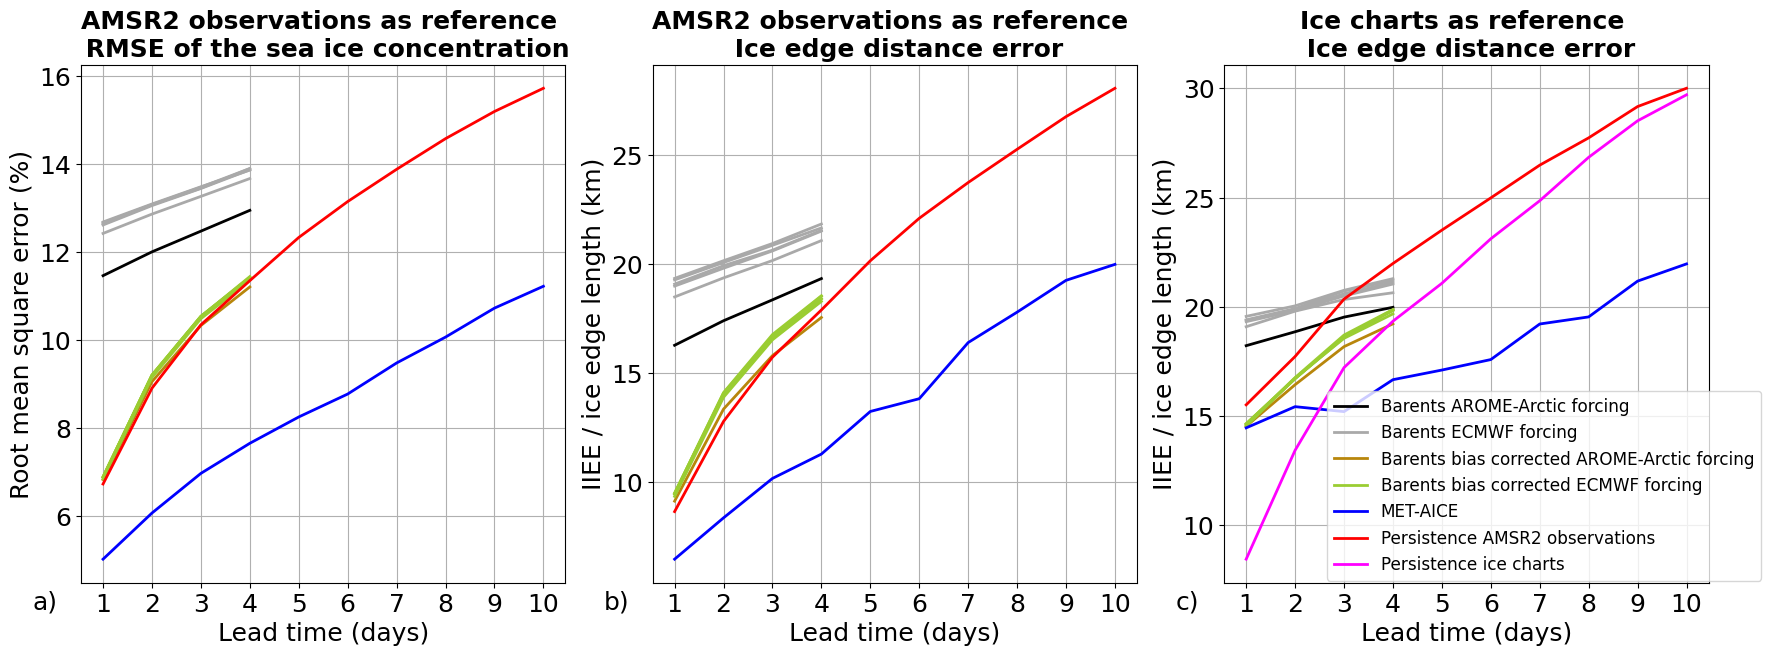

<Figure size 640x480 with 0 Axes>

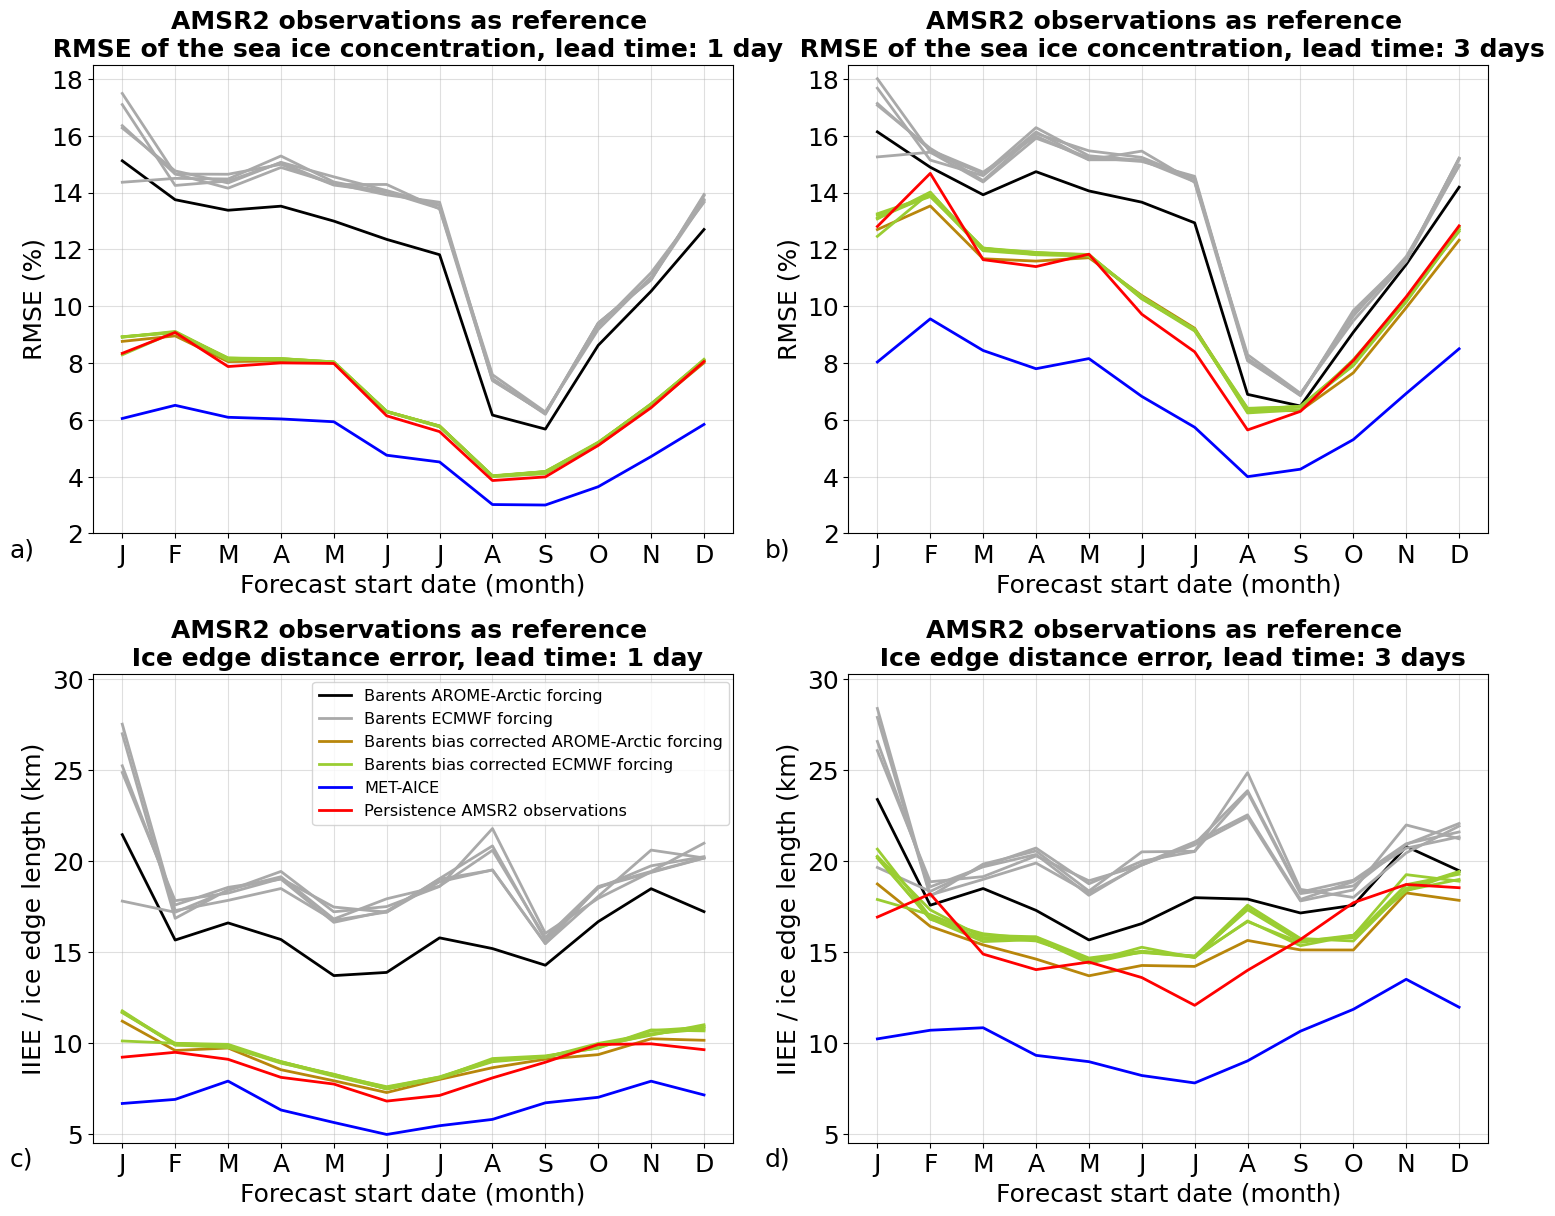

<Figure size 640x480 with 0 Axes>

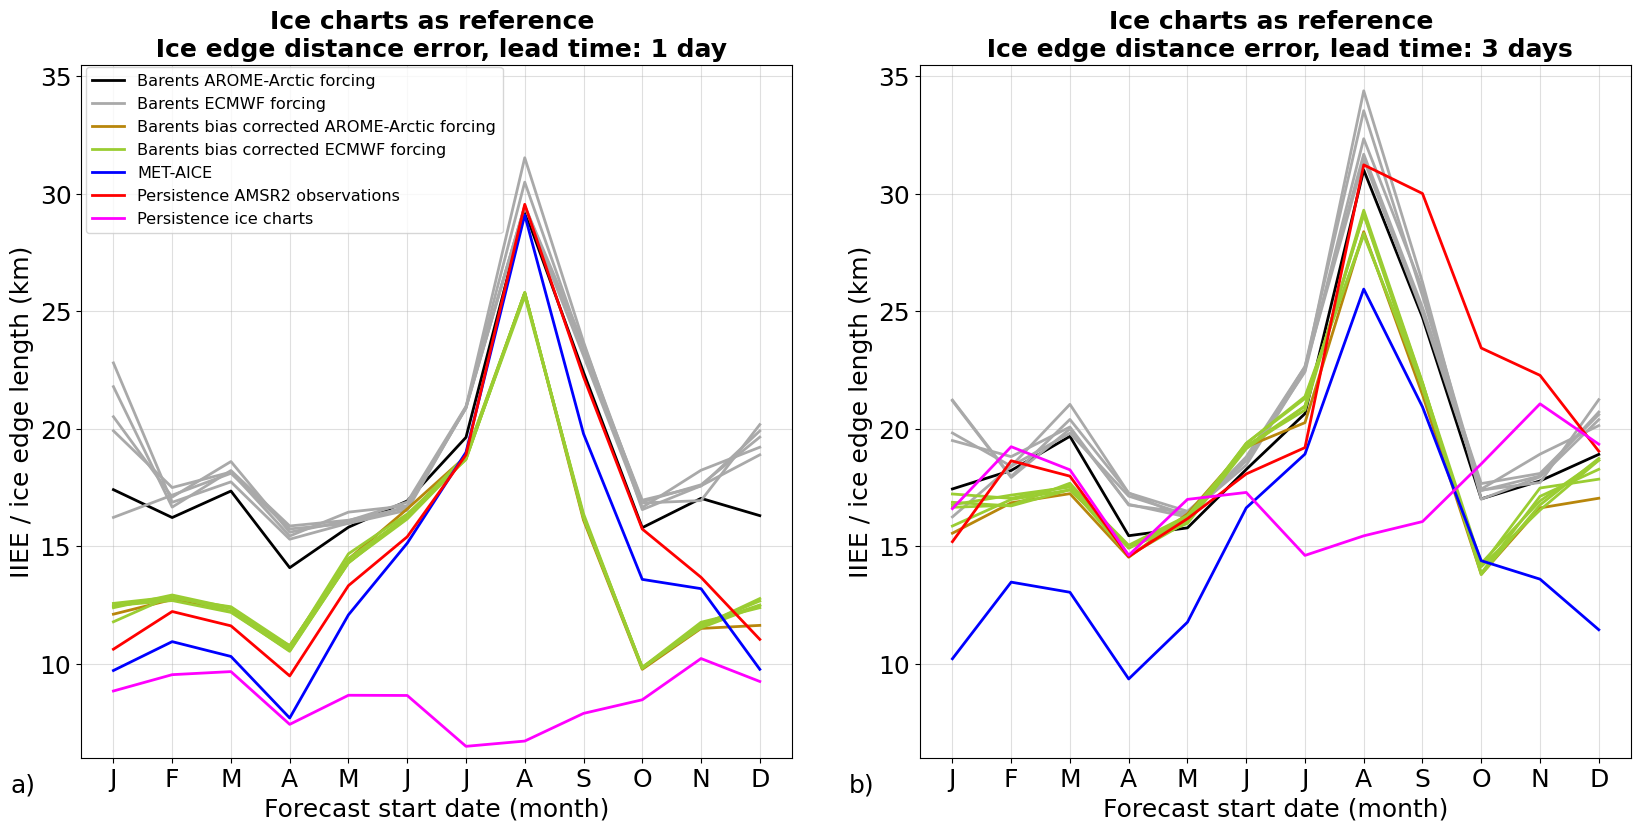

<Figure size 640x480 with 0 Axes>

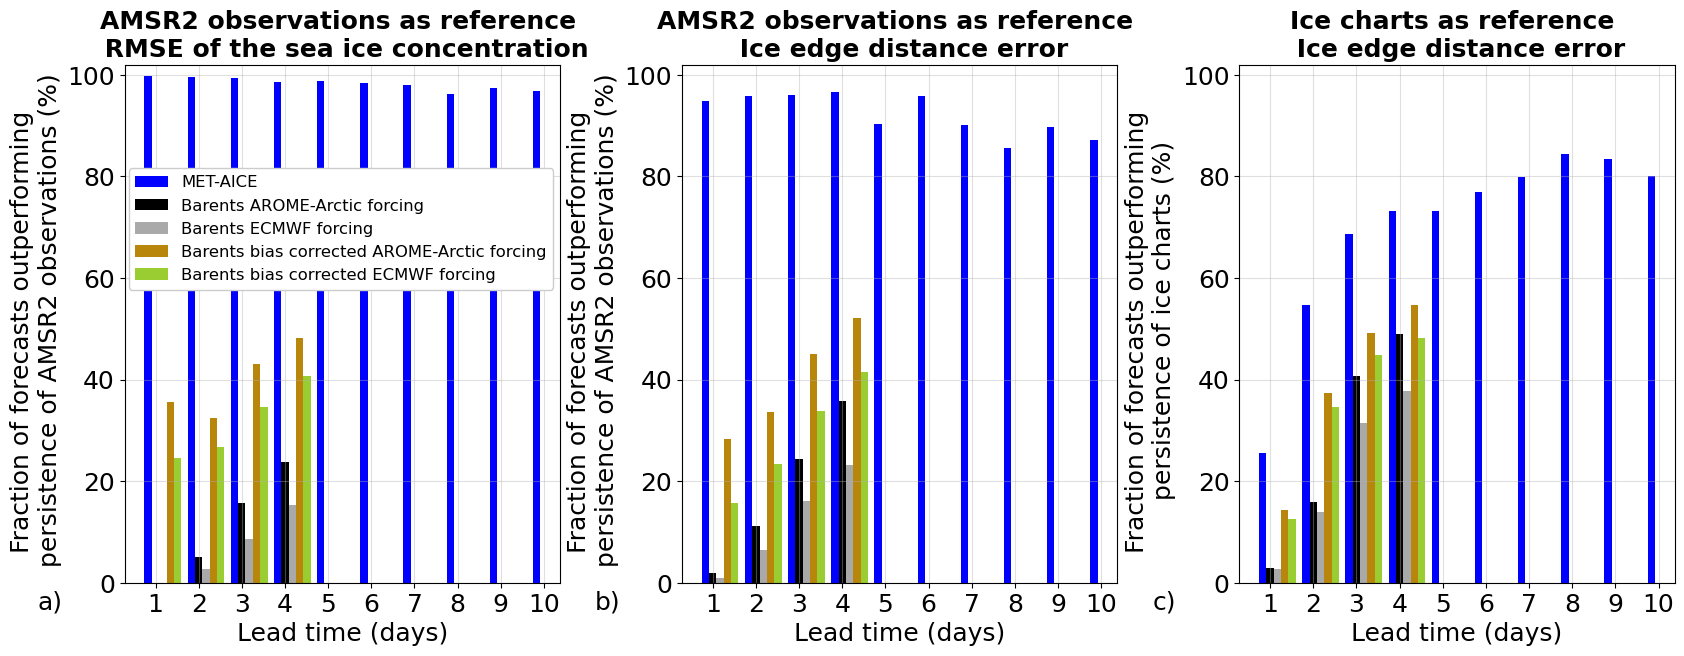

In [8]:
Scores, Monthly_scores, Frac_improved = make_stats(lead_times, paths, date_min_select, date_max_select)
make_figure_IIEE(Scores, lead_times, paths, colors, date_min_select, date_max_select, saving = True)
make_figure_seasonal_variability_AMSR2_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, saving = True)
make_figure_seasonal_variability_ice_charts_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, saving = True)
make_figure_fraction_improved(Frac_improved, lead_times, paths, colors, date_min_select, date_max_select, saving = True)